# Forest

In [1]:
import pandas as pd
import numpy as np
import statistics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import sys
sys.path.append('../../')
from src.elm.elms import ClassicELM, ToeplitzELM, CirculantELM, FastFoodELM, ToeplitzLikeELM, VandermondeELM, LowRankELM
import hpelm
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.initializers import RandomNormal
from sklearn.datasets import fetch_covtype

# Load the dataset from CSV file 
## Before that CSV file must be downloaded from the Kaggle website!

In [ ]:
forest_dataset = pd.read_csv("../datasets/covtype.csv")

y = (forest_dataset.Cover_Type == 2).astype(int)
y[y == 0] = -1

x = forest_dataset.drop("Cover_Type", axis=1)

forest_dataset=None

# OR download the dataset from the internet (almost the same values)
## Downloading takes some time

In [3]:
x, y = fetch_covtype(data_home="../datasets", download_if_missing=True, shuffle=False, return_X_y=True)
y = (y == 2).astype(int)
y[y == 0] = -1

# Preprocessing

In [4]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=481012 / 581012, 
                                                            shuffle=True, random_state=42, stratify=y)
y_train_hp = np.expand_dims(y_train, -1)
y_test_hp = np.expand_dims(y_test, -1)

In [5]:
# Scale
scaler = StandardScaler(copy=False, with_mean=True, with_std=True)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [6]:
x = None
y = None
scaler = None

# Train method

In [7]:
def test(elm_class, neurons_number=200,  trial_number=12, print_every=1,
                regression_tool="ridge_sklearn", alpha=1e-9, s=1, **kwargs):
    training_score = []
    testing_score = []
    stddev = s / (x_train[0].shape[0] ** 0.5)
    for i in range(trial_number):
        elm = elm_class(hidden_neurons=[neurons_number], is_classifier=True, activation="sigmoid", input_shape=x_train[0].shape, use_bias=True,
                     kernel_initializer=RandomNormal(0, stddev), bias_initializer=RandomNormal(0, 1), dev=stddev, **kwargs)
        elm.fit(x_train, y_train, regression_tool=regression_tool, alpha=alpha)
        elm.fit(x_train, y_train, regression_tool=regression_tool, alpha=alpha)
        training_score.append(elm.calculate_classification_accuracy(x_train, y_train))
        testing_score.append(elm.calculate_classification_accuracy(x_test, y_test))
        
        del elm    
        if (i + 1) % print_every == 0:
            print(f"{i + 1}/{trial_number} Training score: {training_score[i]:.{4}}. "
                  f"Testing score: {testing_score[i]:.{4}}")  
    return [training_score, testing_score]

def test_hpelm(neurons_number=200, trial_number=3, print_every=1):
    hpelm_training_rmse = []
    hpelm_testing_rmse = []
    for i in range(trial_number):
        elm = hpelm.ELM(x_train.shape[1], y_train_hp.shape[1])
        elm.add_neurons(neurons_number, "sigm")
        elm.train(x_train, y_train_hp)
        hpelm_training_rmse.append(accuracy_score(y_train_hp > 0, elm.predict(x_train) > 0))
        hpelm_testing_rmse.append(accuracy_score(y_test_hp > 0, elm.predict(x_test) > 0))
        if(i + 1) % print_every == 0:
            print(f"{i + 1}/{trial_number} Training RMSE: {hpelm_training_rmse[i]:.{4}}. Testing RMSE: {hpelm_testing_rmse[i]:.{4}}")
    return [hpelm_training_rmse, hpelm_testing_rmse]    


def print_result(name, training_score, testing_score):
    print(name)
    print(f"Training Score: {statistics.mean(training_score):.{4}}")
    print(f"Testing Score: {statistics.mean(testing_score):.{4}}")

## Train the best ELMs
### Execution will take much time!

In [72]:
classical_scores = []
t_scores = []
c_scores = []
hpelm_scores = []

fastfood_scores = []
low_rank = []

neurons = []

In [75]:
for i in range(4, 10):
    n = i * 200
    neurons.append(n)

    print(f"Neurons: {n}")
    
    print("Hpelm")
    hpelm_scores.append(test_hpelm(neurons_number=n))
    
    print("LowRank ELM")
    low_rank.append(test(ToeplitzLikeELM, neurons_number=n))
    
    print("My classical ELM")
    classical_scores.append(test(ClassicELM, neurons_number=n))
    
    print("Toeplitz ELM")
    t_scores.append(test(ToeplitzELM, neurons_number=n))

    print("Ciculant ELM")
    c_scores.append(test(CirculantELM, neurons_number=n))
    
    print("Fastfood ELM")
    fastfood_scores.append(test(FastFoodELM, neurons_number=n))

    result = [neurons, hpelm_scores, classical_scores, t_scores, c_scores, fastfood_scores, low_rank]
    with open(f"forest/results{n}.p", "wb") as file:
        pickle.dump(result, file)

In [23]:
result = [neurons, hpelm_scores, classical_scores, t_scores, c_scores, fastfood_scores, low_rank]
with open("forest/results_temp.p", "wb") as file:
    pickle.dump(result, file)

# Train bad ELMs
### Execution will take much time!

In [ ]:
vandermonde = test(VandermondeELM, neurons_number=1800, transpose=False, drop_ones=False)
real_low_45 = test(LowRankELM, neurons_number=1800, ranks=[45])
real_low_27 = test(LowRankELM, neurons_number=1800, ranks=[27])

In [16]:
with open("forest/losers_temp.p", "wb") as file:
    pickle.dump([vandermonde, real_low_45, real_low_27], file)

# Results for Figures 4.4, 4.5 and Table 4.2

In [8]:
with open("forest/results.p", "rb") as file:
    [neurons, hpelm_scores, classical_scores, t_scores, c_scores, fastfood_scores, 
     low_rank] = pickle.load(file)

In [9]:
with open("forest/losers.p", "rb") as file:
    [vandermonde, real_low_45, real_low_27] = pickle.load(file)

## Figures 4.4, 4.5 and results for Table 4.2

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

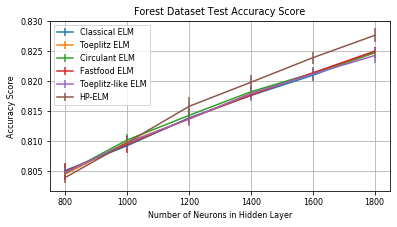

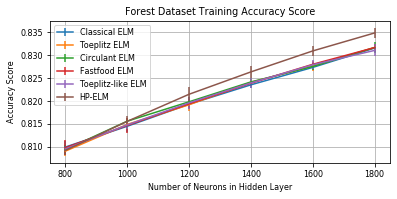

<Figure size 340.157x141.732 with 0 Axes>

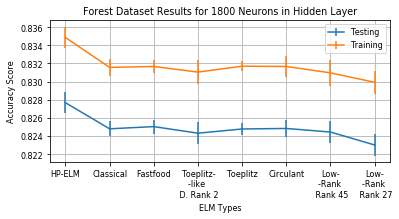

In [10]:
def getAllMeansAndStd(many_scores):
    means = []
    stds = []
    for scores in many_scores:
        (mean, std) = getMeansAndStd(scores)
        means.append(mean)
        stds.append(std)
    return (np.asarray(means), np.asarray(stds))

def getMeansAndStd(scores):
    scores = np.asarray(scores)
    mean = np.mean(scores, axis=-1)
    std = np.std(scores, axis=-1)
    return (mean, std)

start = 0
def plot_scores(scores, neurons, label, start=start, test=True):
    (mean, std) = getMeansAndStd(scores)
    plt.errorbar(neurons[start:], mean[start:, int(test)], std[start:, int(test)], label=label)

figure = plt.figure(figsize=(12/2.54, 6/2.54))
plt.rcParams.update({'font.size': 8})

plot_scores(classical_scores[:], neurons[:], "Classical ELM")

plot_scores(t_scores[:], neurons[:], "Toeplitz ELM")

plot_scores(c_scores[:], neurons[:], "Circulant ELM")

plot_scores(fastfood_scores[:], neurons[:], "Fastfood ELM")

plot_scores(low_rank[:], neurons[:], "Toeplitz-like ELM")

plot_scores(hpelm_scores[:], neurons[:], "HP-ELM")


plt.title("Forest Dataset Test Accuracy Score")
plt.xlabel("Number of Neurons in Hidden Layer")
plt.ylabel("Accuracy Score")

plt.xticks(neurons[start:])
plt.legend()
plt.grid(True)

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

plt.savefig("forest/for_score_test.eps", format='eps', bbox_inches = 'tight',
    pad_inches = 0)

figure = plt.figure(figsize=(12/2.54, 5/2.54))
plt.rcParams.update({'font.size': 8})

plot_scores(classical_scores[:], neurons[:], "Classical ELM", test=False)

plot_scores(t_scores[:], neurons[:], "Toeplitz ELM", test=False)

plot_scores(c_scores[:], neurons[:], "Circulant ELM", test=False)

plot_scores(fastfood_scores[:], neurons[:], "Fastfood ELM", test=False)

plot_scores(low_rank[:], neurons[:], "Toeplitz-like ELM", test=False)

plot_scores(hpelm_scores[:], neurons[:], "HP-ELM", test=False)

plt.title("Forest Dataset Training Accuracy Score")
plt.xlabel("Number of Neurons in Hidden Layer")
plt.ylabel("Accuracy Score")

plt.xticks(neurons[start:])
plt.legend()
plt.grid(True)

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

plt.savefig("forest/for_score_train.eps", format='eps', bbox_inches = 'tight',
    pad_inches = 0)

figure = plt.figure(figsize=(12/2.54, 5/2.54))
plt.rcParams.update({'font.size': 8})

table = []
number = -1

results = [hpelm_scores[number], classical_scores[number], fastfood_scores[number], low_rank[number], 
           t_scores[number], c_scores[number], real_low_45, real_low_27]
names = ["HP-ELM", "Classical", "Fastfood", "Toeplitz-\n-like \n D. Rank 2",
             "Toeplitz", "Circulant","Low-\n-Rank \n Rank 45", "Low-\n-Rank \n Rank 27"]
(means, stds) = getAllMeansAndStd(results)

for i in range(len(names)):
    table.append([names[i], means[i], stds[i]])

figure = plt.figure(figsize=(12/2.54, 5/2.54))
plt.rcParams.update({'font.size': 8})

plt.errorbar(names, means[:, 1], stds[:, 1], label="Testing")
plt.errorbar(names, means[:, 0], stds[:, 0], label="Training")

plt.title("Forest Dataset Results for 1800 Neurons in Hidden Layer") ##!!!!!!!!!!!!
plt.ylabel("Accuracy Score")
plt.xlabel("ELM Types")
plt.grid(True)
plt.legend()  

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.savefig("forest/for_score_1800.eps", format='eps', bbox_inches = 'tight',
    pad_inches = 0)

results = [vandermonde]
names = ["Vandermonde"]
(means, stds) = getAllMeansAndStd(results)
for i in range(len(names)):
    table.append([names[i], means[i], stds[i]])

## Table 4.2

In [11]:
table

[['HP-ELM', array([0.83487083, 0.82767997]), array([0.00118532, 0.00115623])],
 ['Classical',
  array([0.83157083, 0.8247982 ]),
  array([0.00094968, 0.00084375])],
 ['Fastfood',
  array([0.8316725 , 0.82504179]),
  array([0.00071279, 0.0007644 ])],
 ['Toeplitz-\n-like \n D. Rank 2',
  array([0.8310525 , 0.82431554]),
  array([0.00129665, 0.00123598])],
 ['Toeplitz',
  array([0.8317025 , 0.82477932]),
  array([0.00055142, 0.00070901])],
 ['Circulant',
  array([0.83167333, 0.82483822]),
  array([0.00120685, 0.00090107])],
 ['Low-\n-Rank \n Rank 45',
  array([0.8309675 , 0.82444253]),
  array([0.00144993, 0.00118447])],
 ['Low-\n-Rank \n Rank 27',
  array([0.8299275 , 0.82301464]),
  array([0.00125027, 0.00116516])],
 ['Vandermonde',
  array([0.74259583, 0.7390105 ]),
  array([0.00946249, 0.00955222])]]

# Train with differents s (deviation = s / sqrt(number of inputs))
## Not part of the thesis
### Execution will take much time!

In [9]:
results = []
results.append(test(ClassicELM, s=1, trial_number=3, alpha=1e-9, neurons_number=1200))
results.append(test(ClassicELM, s=2, trial_number=3, alpha=1e-9, neurons_number=1200))
results.append(test(ClassicELM, s=3, trial_number=3, alpha=1e-9, neurons_number=1200))
results.append(test(ClassicELM, s=4, trial_number=3, alpha=1e-9, neurons_number=1200))
results.append(test(ClassicELM, s=5, trial_number=3, alpha=1e-9, neurons_number=1200))

1/3 Training score: 0.8193. Testing score: 0.8136
2/3 Training score: 0.8197. Testing score: 0.8145
3/3 Training score: 0.8204. Testing score: 0.8143


/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.05215e-09): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.05215e-09): result may not be accurate.
  overwrite_a=True).T


1/3 Training score: 0.8199. Testing score: 0.8143


/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.37712e-10): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.37712e-10): result may not be accurate.
  overwrite_a=True).T


2/3 Training score: 0.8223. Testing score: 0.8161


/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.23668e-09): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.23668e-09): result may not be accurate.
  overwrite_a=True).T


3/3 Training score: 0.8215. Testing score: 0.8157


/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.13949e-09): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.13949e-09): result may not be accurate.
  overwrite_a=True).T


1/3 Training score: 0.821. Testing score: 0.8156


/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.60093e-09): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.60093e-09): result may not be accurate.
  overwrite_a=True).T


2/3 Training score: 0.8213. Testing score: 0.8159


/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.81239e-09): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.81239e-09): result may not be accurate.
  overwrite_a=True).T


3/3 Training score: 0.8215. Testing score: 0.8163


/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.36291e-08): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.36291e-08): result may not be accurate.
  overwrite_a=True).T


1/3 Training score: 0.8219. Testing score: 0.8155


/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.88471e-08): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.88471e-08): result may not be accurate.
  overwrite_a=True).T


2/3 Training score: 0.8209. Testing score: 0.8154


/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.44842e-08): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.44842e-08): result may not be accurate.
  overwrite_a=True).T


3/3 Training score: 0.8214. Testing score: 0.8144


/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.02584e-08): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.02584e-08): result may not be accurate.
  overwrite_a=True).T


1/3 Training score: 0.8202. Testing score: 0.8146


/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.18814e-08): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.18814e-08): result may not be accurate.
  overwrite_a=True).T


2/3 Training score: 0.8219. Testing score: 0.815


/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.60301e-08): result may not be accurate.
  overwrite_a=True).T
/Users/russii/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.60301e-08): result may not be accurate.
  overwrite_a=True).T


3/3 Training score: 0.818. Testing score: 0.8126


In [ ]:
axis = [1, 2, 3, 4, 5]
save = [axis, results]
with open(f"forest/s_temp.p", "wb") as file:
        pickle.dump(save, file)

## Results for different s

In [12]:
with open(f"forest/s.p", "rb") as file:
        [axis, results] = pickle.load(file)                

Text(0, 0.5, 'Accuracy score')

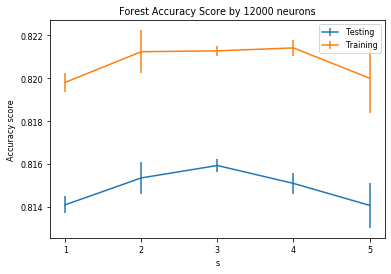

In [13]:
np_results = np.asarray(results)
plt.errorbar(axis, np.mean(np_results, axis=-1)[:, 1], np.std(np_results, axis=-1)[:, 1], label="Testing")
plt.errorbar(axis, np.mean(np_results, axis=-1)[:, 0], np.std(np_results, axis=-1)[:, 0], label="Training")
plt.xticks(axis)
plt.legend()
plt.title("Forest Accuracy Score by 12000 neurons")
plt.xlabel("s")
plt.ylabel("Accuracy score")